# Skip logic & scenarios
This notebook provides example EDSL code for using a language model to simulate a survey that uses skip logic: rules for determining which questions are administered based on responses to other questions in the survey. 

In the first example below we construct a survey of questions and then add a rule to skip one question based on the response to another question.

In the second example we add some complexity. We first create different "scenarios" (versions) of questions and combine them in a survey. Then we add multiple rules to skip specific versions of the questions based on responses to a particular version of a question. 

[EDSL is an open-source library](https://github.com/expectedparrot/edsl) for simulating surveys, experiments and other research with AI agents and large language models. 
Before running the code below, please ensure that you have [installed the EDSL library](https://docs.expectedparrot.com/en/latest/installation.html) and either [activated remote inference](https://docs.expectedparrot.com/en/latest/remote_inference.html) from your [Coop account](https://docs.expectedparrot.com/en/latest/coop.html) or [stored API keys](https://docs.expectedparrot.com/en/latest/api_keys.html) for the language models that you want to use with EDSL. Please also see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started using EDSL.

## Example 1
In the first example below we construct questions, combine them in a survey, and add a rule to skip the second question based on the response to the first question.
Then we create `Scenario` objects for contents that will be added to the questions when the survey is run.
The effect of this is that the second question will be skipped based on the response to the first question for each individual scenario.

We start by constructing questions:

In [1]:
from edsl import QuestionYesNo, QuestionNumerical, QuestionMultipleChoice

q1 = QuestionYesNo(
    question_name = "recent_purchase",
    question_text = "In the last year have you or anyone in your household purchased any {{ scenario.item }}?",
)

q2 = QuestionNumerical(
    question_name = "amount",
    question_text = "In the last year, how much did your household spend on {{ scenario.item }} (in USD)?"
)

q3 = QuestionMultipleChoice(
    question_name = "next_purchase",
    question_text = "When do you next expect to purchase {{ scenario.item }}?", 
    question_options = [
        "Never",
        "Within the next month",
        "Within the next year",
        "I do not know"
    ]
)

We combine the questions in a survey to administer them together:

In [2]:
from edsl import Survey

survey = Survey(questions = [q1, q2, q3])
survey

,question_options,question_name,question_type,question_text
0,"['No', 'Yes']",recent_purchase,yes_no,In the last year have you or anyone in your household purchased any {{ scenario.item }}?
1,nan,amount,numerical,"In the last year, how much did your household spend on {{ scenario.item }} (in USD)?"
2,"['Never', 'Within the next month', 'Within the next year', 'I do not know']",next_purchase,multiple_choice,When do you next expect to purchase {{ scenario.item }}?


Here we add a rule to skip q2 based on the response to q1:

In [3]:
survey = survey.add_skip_rule(q2, "{{ recent_purchase.answer }} == 'No'")

Next we create scenarios for the "item" to be used with each question:

In [4]:
from edsl import Scenario, ScenarioList

s = ScenarioList(
    Scenario({"item":item}) for item in ["electronics", "phones"]
)

Note that we could also use a method for the data type that we are using--this is equivalent:

In [5]:
s = ScenarioList.from_list("item", ["electronics", "phones"])
s

,item
0,electronics
1,phones


We can inspect the flow of the survey that has been created with the scenarios that we're using:

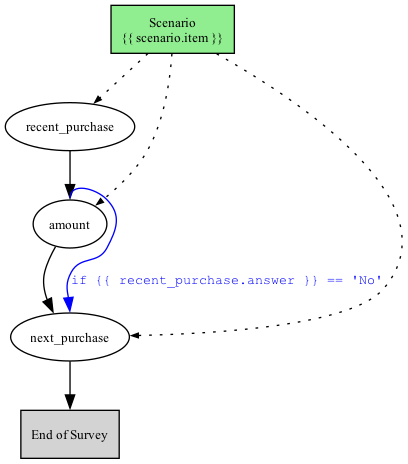

In [6]:
survey.by(s).show_flow()

Next we create some agent personas to answer the questions:

In [7]:
from edsl import Agent, AgentList

income_levels = ["under $100,000", "$100,000-250,000", "above $250,000"]
ages = [30, 50, 70] 

a = AgentList(
    Agent({"annual_income":income, "age":age}) for income in income_levels for age in ages
)
a

,annual_income,age
0,"under $100,000",30
1,"under $100,000",50
2,"under $100,000",70
3,"$100,000-250,000",30
4,"$100,000-250,000",50
5,"$100,000-250,000",70
6,"above $250,000",30
7,"above $250,000",50
8,"above $250,000",70


Next we select a model to generate the responses ([check available models and pricing](https://www.expectedparrot.com/getting-started/coop-pricing)):

In [8]:
from edsl import Model

m = Model("gemini-1.5-flash")

We can inspect (or modify) the default parameters of the model that will be used:

In [9]:
m

,key,value
0,model,gemini-1.5-flash
1,parameters:temperature,0.500000
2,parameters:topP,1
3,parameters:topK,1
4,parameters:maxOutputTokens,2048
5,parameters:stopSequences,[]
6,inference_service,google


We run the survey by adding any scenarios, agents and models and then calling the `run`:

In [10]:
results = survey.by(s).by(a).by(m).run()

We can inspect a list of the columns of the dataset of results that has been generated:

In [11]:
results.columns

,0
0,agent.age
1,agent.agent_index
2,agent.agent_instruction
3,agent.agent_name
4,agent.annual_income
5,answer.amount
6,answer.next_purchase
7,answer.recent_purchase
8,cache_keys.amount_cache_key
9,cache_keys.next_purchase_cache_key


We can select and inspect any components of the results.
We can see by a "None" response that a question was skipped:

In [12]:
(
    results
    .sort_by("annual_income", "age", "item")
    .select("model", "annual_income", "age", "item", "recent_purchase", "amount", "next_purchase")
)

,model.model,agent.annual_income,agent.age,scenario.item,answer.recent_purchase,answer.amount,answer.next_purchase
0,gemini-1.5-flash,"$100,000-250,000",30,electronics,Yes,2500.000000,Within the next year
1,gemini-1.5-flash,"$100,000-250,000",30,phones,Yes,1200.000000,Within the next year
2,gemini-1.5-flash,"$100,000-250,000",50,electronics,Yes,2500.000000,Within the next year
3,gemini-1.5-flash,"$100,000-250,000",50,phones,Yes,1200.000000,Within the next year
4,gemini-1.5-flash,"$100,000-250,000",70,electronics,Yes,500.000000,Within the next year
5,gemini-1.5-flash,"$100,000-250,000",70,phones,No,nan,Within the next year
6,gemini-1.5-flash,"above $250,000",30,electronics,Yes,5000.000000,Within the next year
7,gemini-1.5-flash,"above $250,000",30,phones,Yes,0.000000,Within the next year
8,gemini-1.5-flash,"above $250,000",50,electronics,Yes,5000.000000,Within the next year
9,gemini-1.5-flash,"above $250,000",50,phones,Yes,0.000000,Within the next year


## Example 2
In the next example, we use the same scenarios to create versions of the questions *before we combine them in a survey*.
This allows us to add a skip rule based on a question/scenario combination, as opposed to skipping a question for all scenarios:

In [13]:
q1 = QuestionYesNo(
    question_name = "recent_purchase_{{ scenario.item }}",
    question_text = "In the last year have you or anyone in your household purchased any {{ scenario.item }}?",
)

q2 = QuestionNumerical(
    question_name = "amount_{{ item }}",
    question_text = "In the last year, how much did your household spend on {{ scenario.item }} (in USD)?"
)

q3 = QuestionMultipleChoice(
    question_name = "next_purchase_{{ scenario.item }}",
    question_text = "When do you next expect to purchase {{ scenario.item }}?", 
    question_options = [
        "Never",
        "Within the next month",
        "Within the next year",
        "I do not know"
    ]
)

The `loop` method creates new versions of questions with scenarios already inserted:

In [14]:
questions = q1.loop(s) + q2.loop(s) + q3.loop(s)
questions

[Question('yes_no', question_name = """recent_purchase_electronics""", question_text = """In the last year have you or anyone in your household purchased any electronics?""", question_options = ['No', 'Yes']),
 Question('yes_no', question_name = """recent_purchase_phones""", question_text = """In the last year have you or anyone in your household purchased any phones?""", question_options = ['No', 'Yes']),
 Question('numerical', question_name = """amount_electronics""", question_text = """In the last year, how much did your household spend on electronics (in USD)?""", min_value = None, max_value = None),
 Question('numerical', question_name = """amount_phones""", question_text = """In the last year, how much did your household spend on phones (in USD)?""", min_value = None, max_value = None),
 Question('multiple_choice', question_name = """next_purchase_electronics""", question_text = """When do you next expect to purchase electronics?""", question_options = ['Never', 'Within the next 

We combine the questions in a survey to administer them together the same as before:

In [15]:
survey = Survey(questions)

Here we add different rules specifying that questions with one scenario (phones) should be administered or skipped based on the answer to a question with another scenario (electronics):

In [16]:
survey = (
    survey
    .add_skip_rule("recent_purchase_phones", "{{ recent_purchase_electronics.answer }} == 'No'")
    .add_skip_rule("amount_phones", "{{ recent_purchase_electronics.answer }} == 'No'")
    .add_skip_rule("next_purchase_phones", "{{ recent_purchase_electronics.answer }} == 'No'")
)

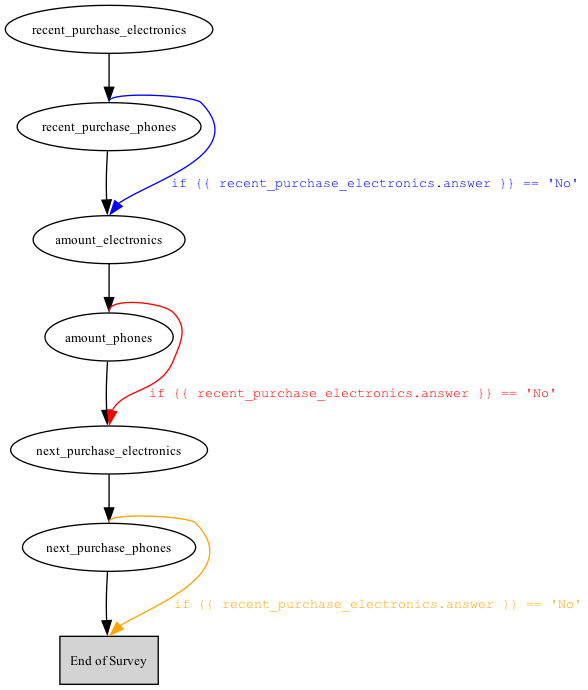

In [17]:
survey.show_flow()

Here we run the survey with the scenarios, agents and model:

In [18]:
results = survey.by(a).by(m).run()

There is no "scenario" field in results because the scenarios were already added to questions.
Instead, there are separate columns for each version of a question:

In [19]:
(
    results
    .sort_by("annual_income", "age")
    .select("model", "annual_income", "age", "recent_purchase_electronics", "amount_electronics", "next_purchase_electronics", "recent_purchase_phones", "amount_phones", "next_purchase_phones")
)

,model.model,agent.annual_income,agent.age,answer.recent_purchase_electronics,answer.amount_electronics,answer.next_purchase_electronics,answer.recent_purchase_phones,answer.amount_phones,answer.next_purchase_phones
0,gemini-1.5-flash,"$100,000-250,000",30,Yes,2500,Within the next year,Yes,1200.000000,Within the next year
1,gemini-1.5-flash,"$100,000-250,000",50,Yes,2500,Within the next year,Yes,1200.000000,Within the next year
2,gemini-1.5-flash,"$100,000-250,000",70,Yes,500,Within the next year,No,0.000000,Within the next year
3,gemini-1.5-flash,"above $250,000",30,Yes,5000,Within the next year,Yes,0.000000,Within the next year
4,gemini-1.5-flash,"above $250,000",50,Yes,5000,Within the next year,Yes,0.000000,Within the next year
5,gemini-1.5-flash,"above $250,000",70,Yes,5000,Within the next year,No,0.000000,Never
6,gemini-1.5-flash,"under $100,000",30,Yes,250,Within the next year,No,300.000000,Within the next year
7,gemini-1.5-flash,"under $100,000",50,No,250,Within the next year,nan,nan,nan
8,gemini-1.5-flash,"under $100,000",70,No,0,Within the next year,nan,nan,nan


## Posting to the Coop
Here we post this notebook to the Coop, a free platform for creating and sharing AI-based research (learn more about [how it works](https://docs.expectedparrot.com/en/latest/coop.html)):

In [20]:
from edsl import Notebook

nb = Notebook(path = "skip_logic_scenarios.ipynb")

nb.push(
    description = "Using skip logic with question scenarios", 
    alias = "skip-logic-scenarios",
    visibility = "public"
)

{'description': 'Using skip logic with question scenarios',
 'object_type': 'notebook',
 'url': 'https://www.expectedparrot.com/content/d91d29a1-607e-4a98-a962-a662c7f94399',
 'alias_url': 'https://www.expectedparrot.com/content/RobinHorton/skip-logic-scenarios',
 'uuid': 'd91d29a1-607e-4a98-a962-a662c7f94399',
 'version': '0.1.62.dev1',
 'visibility': 'public'}